# The Following is a comparison of Data taken from the Hebrew University  Faculty of Agriculture Meteorological station and Data from a DIY  Meteorolgical station  made with sensors  and the Arduino platform.
http://www.meteo-tech.co.il/faculty/faculty_download.asp?client=1

https://thingspeak.com/channels/1690485

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from pathlib import Path 



In [2]:
def read_file(file_path, folder_path="C:/Users/Zev Rozman/Desktop/agrotech"): #erase and insert the location of the files 
    # note that when you go to location of the file the slashes may be the other direction (slanted tot he left). so switch them so they slant to the right. 
    folder_path = Path(folder_path)       
    input_file = os.path.join(folder_path, file_path)
    
    ext = input_file.split(".")[-1]
    if ext == "csv":
        return pd.read_csv(input_file)
    else:
        return pd.read_excel(input_file)

In [3]:
df= read_file("faculta_meteo_station_9.5.22.xlsx")
df1=read_file("Evapotrans_proj_data_8-13.7.22.xlsx")

#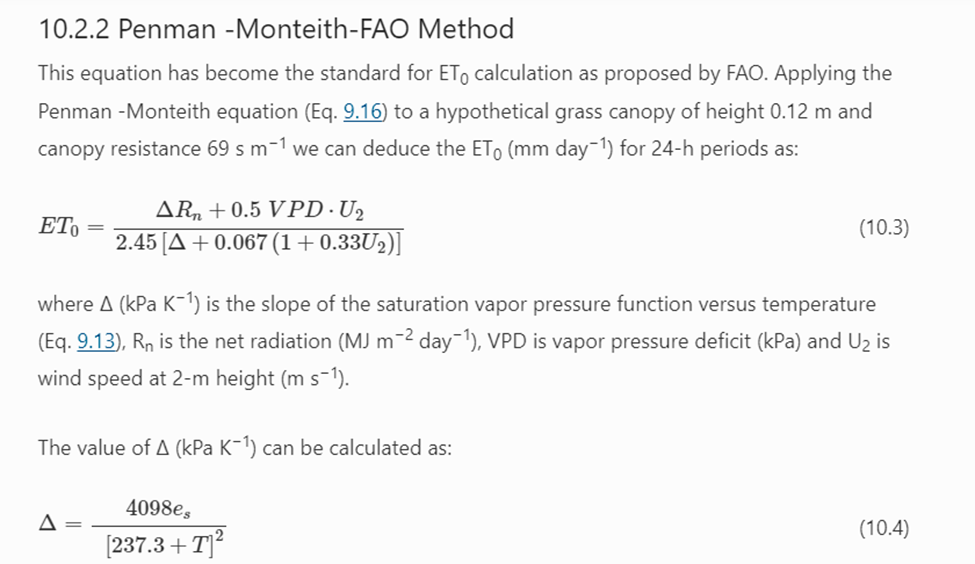

#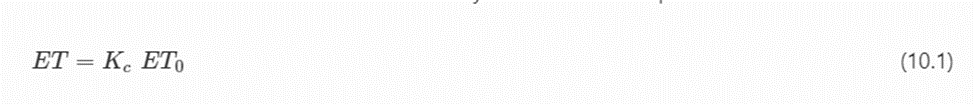
#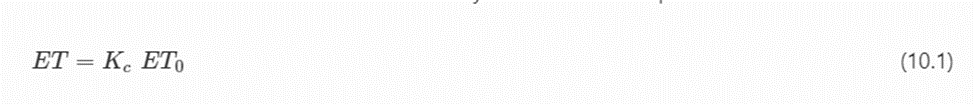

#Images of simplified taken from- https://link.springer.com/book/10.1007/978-3-319-46116-8

In [4]:
# to calculate VPD
df["e"]=2.71828
df["m"] = df["Temp C 2m"] / (df["Temp C 2m"] + 238.3) * 17.2694
df['SVP'] = 610.78 * pow(df["e"], df["m"])
df['f'] = 1 - df["RH"] / 100
df["VPD"]= (df['SVP'] *df['f'])/1000
#it seams i need to deal with the NANs?

# part 1 ETo
df['RadiationMJ/m2day']=df["Rad W/M2"]*86400/1000000
df["es_part1"]=df["Temp C 2m"]*17.27
df["es_part2"]=df["Temp C 2m"]+237.3
df["es_part3"]=df["es_part1"]/df["es_part2"]
df["es_final"]=pow(0.61078,(df["es_part3"]))
#part 2 ETo
df["delta_part1"]=df["es_final"]*4098   
df["delta_part2"]=pow(df["es_part2"],2)
df["delta_final"]=df["delta_part1"]/df["delta_part2"]
#part 3 ETo
df['Kc']=1 # change according to specific crop coefficient
df["wind_m/s"]=df["Wind km/h"]/3.6
df['et0_part1']=2.45*(df["delta_final"]+0.067*(df["wind_m/s"]+0.33*df["wind_m/s"]))
df["et0_final_mm/day"]=df['Kc']* (((df["delta_final"]*df['RadiationMJ/m2day'])+0.5*df["VPD"]*df["wind_m/s"])/df['et0_part1'])

the following code regards the Faculty Station and is to turn the data from column into a string so it can be read properly

In [5]:
x1=df["Time"]
df['Date_str'] = df['Date'].astype(str)
#print(df['Date_str'] )
df['Time_str'] = df['Time'].astype(str)
df['timestamp'] = df['Date_str'] + ' ' + df['Time_str']
#print(df['timestamp'])
##in the following line "format" specification allows me to switch the values of "%d-%m" so that it switches its reading of days and month. This is a "cheating" method and wont work for days>12.
df['timestamp'] = pd.to_datetime(df['timestamp'],format= "%Y-%d-%m %H:%M:%S")
df = df.set_index('timestamp')
#print(df.index)

In [6]:
#print df to see the format after adding all the columns for the calculation and creating an index of "timestamp"
#df

# The Following is for the DYI Arduino Based Meteorological station Data

In [7]:
df1["created_at"] = pd.to_datetime(df1["created_at"])
df1 = df1.set_index("created_at")
#df1

In [8]:
df.index = df.index - pd.Timedelta(days=0) 
# this allows us to align/overlap the data from different ates by moving them back the amount of days written

<IPython.core.display.Javascript object>


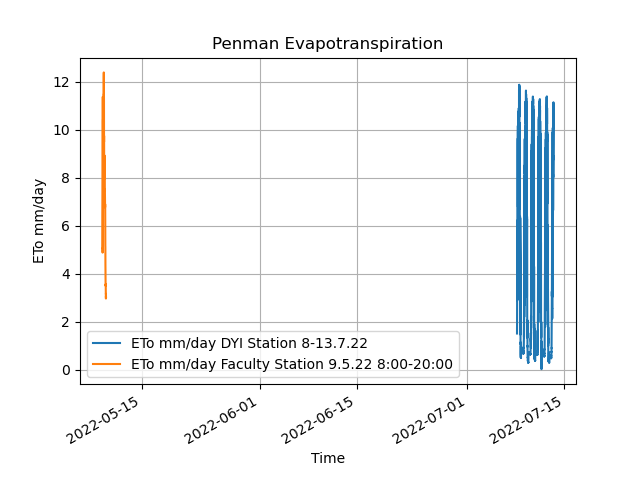

In [9]:
%matplotlib notebook 
# for better visulalization of the figure. This allows you to zoom in and move around on the graph 

plt.plot(df1["Penman Eto"], label="ETo mm/day DYI Station 8-13.7.22 ")
plt.plot(df["et0_final_mm/day"], label="ETo mm/day Faculty Station 9.5.22 8:00-20:00")
plt.title("Penman Evapotranspiration")
plt.title("Penman Evapotranspiration")
plt.xlabel("Time")
plt.ylabel("ETo mm/day")
plt.legend()
plt.grid()
plt.savefig("Comparing Penman Evapotranspiration.png", dpi=300)
#plt.rcParams["figure.figsize"] = (10,10) 
plt.gcf().autofmt_xdate() #this formats X axis from both data sets. 


# Discussion 
We See Above a comparison of two different Meteorological Stations calculation of Penman Evapotranspiration. In Blue we wee a DYI Arduino and Sensors based station (located within a greenhouse) and in Orange we see a the Faculty Station with Sensors of MeteoTech. We see from aligning the data on the same graph recieves similar ET measurements indicating the functionality of the DYI station. 

( We used the shown above calculation for the Faculty Station since that is what was used on the arduino platform for the DYI station) . For independant calculation of penman try  pip install pyet)


Possible reasons for discrepency between the stations inlude:
1. Different Sensors (Specifically the sensors used for this calculation are: Solar Radiation, Temperature & RH (used for VPD calculation)).  
2. The DYI station did not include a windspeed anenometer and so for the calculation windspeed was set at a constant 1m/s.
3. The DYI station was is located in a greenhouse, the Faculty Station is outside
4. the Locations are different (roughly 2 km apart. DYI- 31.906598256053613, 34.80320071204175. Faculty Station-31.907704620496148, 34.80109871005005)  
5. The collected data are from different dates (the Faculty Station did not have data since our DYI Station has been running).


For Improvement:
1. The dataframe from the excel from the Faculty Station reads Month/Day/Year. 

df['timestamp'] = pd.to_datetime(df['timestamp'],format= "%Y-%d-%m %H:%M:%S") 

here i "trick" the program to reading Day as Month and vice versa. This wouldnt work for days of the month above 12 and needs to be done properly at the stage of first reading the file. 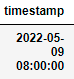 This is a snip of the printed df indexes. 